In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob as gl
import os
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [4]:
path = "src/results"

""" datetime = "/2011-03-24_15"
df = pd.read_csv(path + datetime + '.csv')  """


dfs = []

for file in gl.glob(path + '/20*.csv'):
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs, ignore_index=True)
#df.count() #cada csv tiene 160920 filas

## Label Encoder

In [5]:
modelo = df.iloc[:, 8].values 
from sklearn.preprocessing import LabelEncoder
modelo = LabelEncoder().fit_transform(modelo) #codificación del modelo

In [6]:
df = df.drop(df.columns[8], axis=1) #se elimina la antigua con los strings del modelo
df['modelo'] = modelo #se añade la nueva codificada al final

X = df.iloc[:, 1:] 
X = X.drop(['datetime', 'timestamp', 'load', 'DC Array Output (W)' , 'Pavg', 'dif'], axis=1)
y = df.iloc[:, 0].values #valores de overflow

X.columns

Index(['cap', 'dist', 'origen_id', 'dest_id', 'len_origen_tag', 'len_dest_tag',
       'criterion', 'degree', 'total_balance', 'abs_flux', 'h',
       'Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)', 'modelo'],
      dtype='object')

## Split

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() #escalado de datos
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_test

array([[ 1.32034177, -0.31014732, -0.01363586, ..., -1.38649441,
        -0.69532519,  1.00009322],
       [-1.10454301, -0.24729923,  1.19677632, ..., -1.78672648,
        -1.72510414, -0.99990679],
       [-0.24113707, -1.18216452, -1.37534955, ..., -0.45570284,
        -0.40905598,  1.00009322],
       ...,
       [ 1.32034177,  1.55958327, -0.46754042, ..., -1.78672648,
        -1.72510414, -0.99990679],
       [-1.10454301,  0.62078997, -0.46754042, ..., -0.45570284,
        -0.40905598,  1.00009322],
       [-1.10454301, -1.11146042,  0.44026871, ...,  1.70315782,
         2.1370159 ,  1.00009322]])

## PCA

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0) #estimators = trees
classifier.fit(X_train, y_train)
#classifier.fit(X_train_pca, y_train)
classifier.estimators_

[DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=209652396),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=398764591),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=924231285),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=1478610112),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=441365315),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=1537364731),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=192771779),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=1491434855),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
           

In [9]:
#y_pred = classifier.predict(X_test)
y_pred = classifier.predict(X_test_pca)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


## Evaluación

### Matriz de confusión

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
#y_pred = classifier.predict(X_test)
y_pred = classifier.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

#0.9912896677438064 || [[376752    392] [  2972   6092]] sin PCA
#0.9752335529041346 || [[376593    551] [  9014     50]] con PCA

[[376593    551]
 [  9014     50]]


0.9752335529041346

### K-Fold

In [12]:
from sklearn.model_selection import cross_val_score

#accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies = cross_val_score(estimator = classifier, X = X_train_pca, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

#Accuracy: 99.09 % Standard Deviation: 0.02 % sin PCA
#Accuracy: 97.54% Standard Deviation:  0.01% con PCA

Accuracy: 97.54 %
Standard Deviation: 0.01 %


## Figuras

In [12]:
X_set, y_set = X_train, y_train
X.columns

Index(['cap', 'dist', 'origen_id', 'dest_id', 'len_origen_tag', 'len_dest_tag',
       'criterion', 'degree', 'total_balance', 'abs_flux', 'h',
       'Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)', 'modelo'],
      dtype='object')

<Figure size 1000x600 with 0 Axes>

In [16]:
X.describe

<bound method NDFrame.describe of           cap  dist  origen_id  dest_id  len_origen_tag  len_dest_tag  \
0        40.0   443         18        7               9             8   
1        74.0   186         18        9               7             6   
2        74.0   518         18        9               7             6   
3        21.2   692         18        1               6             5   
4        21.2   633         18       21               5             4   
...       ...   ...        ...      ...             ...           ...   
1931035  40.0   271         22        3               5             4   
1931036  40.0   432         22        2               4             3   
1931037  40.0   346         22       22               3             2   
1931038  74.0    46         22       11               2             1   
1931039  74.0   377         22       11               2             1   

         criterion  degree  total_balance     abs_flux   h  \
0                0       2 

In [14]:
plt.figure(figsize=(10, 6))

X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01))

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha=0.75, cmap=ListedColormap(('red', 'green')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c=ListedColormap(('red', 'green'))(i), label=j)

plt.title('RF (Conjunto de Entrenamiento)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

ValueError: X has 2 features, but RandomForestClassifier is expecting 17 features as input.

<Figure size 1000x600 with 0 Axes>

## Figuras mal

C:\Users\Paula\AppData\Local\Temp\ipykernel_18416\165783590.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],


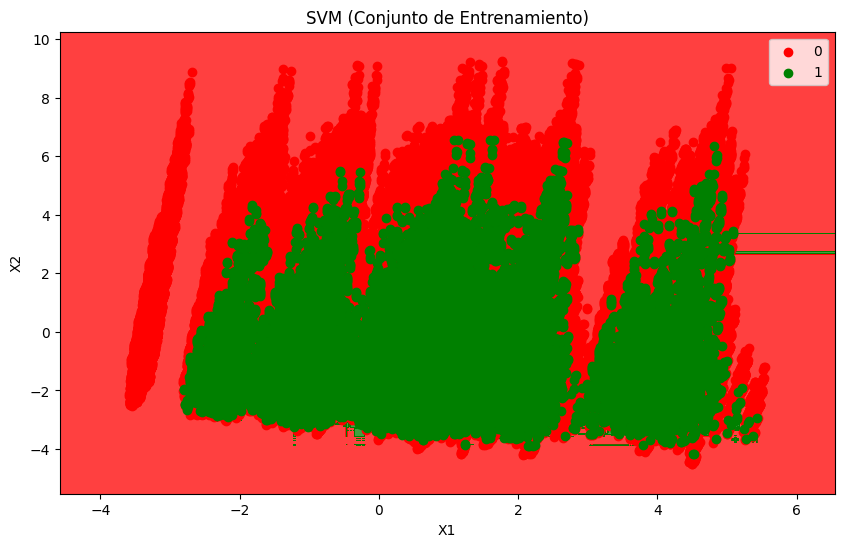

In [13]:
plt.figure(figsize=(10, 6))

X_set, y_set = X_train_pca, y_train
X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01))

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha=0.75, cmap=ListedColormap(('red', 'green')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c=ListedColormap(('red', 'green'))(i), label=j)

plt.title('RF (Conjunto de Entrenamiento)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

C:\Users\Paula\AppData\Local\Temp\ipykernel_18416\3445447182.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],


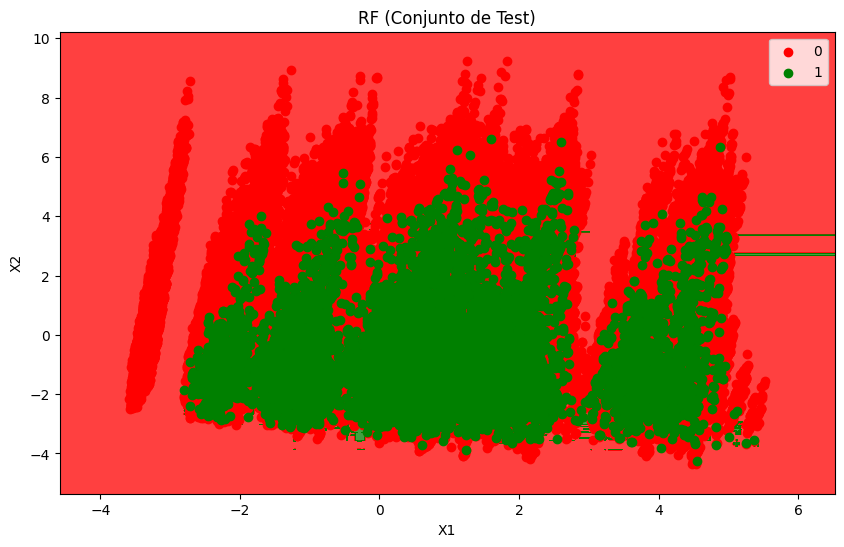

In [15]:
plt.figure(figsize=(10, 6))

X_set, y_set = X_test_pca, y_test
X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01))

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha=0.75, cmap=ListedColormap(('red', 'green')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c=ListedColormap(('red', 'green'))(i), label=j)

plt.title('RF (Conjunto de Test)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

In [ ]:
X_set, y_set = sc.inverse_transform(X_train), y_train

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 10, stop = X_set[:, 0].max() + 10, step = 0.25),
                     np.arange(start = X_set[:, 1].min() - 1000, stop = X_set[:, 1].max() + 1000, step = 0.25))

plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'blue')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'blue'))(i), label = j)

plt.title('Random Forest (Set de entrenamiento)')
plt.xlabel('X')
plt.ylabel('Overflow')
plt.legend()
plt.show()

c:\Users\Paula\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 2 features, but StandardScaler is expecting 17 features as input.

In [ ]:
X_set, y_set = sc.inverse_transform(X_test), y_test

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 10, stop = X_set[:, 0].max() + 10, step = 0.25),
                     np.arange(start = X_set[:, 1].min() - 1000, stop = X_set[:, 1].max() + 1000, step = 0.25))

plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'blue')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'blue'))(i), label = j)

plt.title('Random Forest (Set de test)')
plt.xlabel('X')
plt.ylabel('Overflow')
plt.legend()
plt.show()

## Grid Search

In [ ]:
parameters = {
    'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
    'criterion': ['entropy', 'gini']
        }
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)